In [1]:
import numpy as np
import pandas as pd
import scipy.io as sio
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import pdb

% matplotlib inline

In [2]:
data_info = pd.read_csv('/data/Good data_store.csv')
data_info.head()

,File name,Age,Pip number,E-I,Reci,Artifact,IS100,Trial number before,Trial number after,Protocol,Elimi,Notes,Ptl_note
0,2016072704,27,3,0,0,0,1,"26,27,28,29","31,32,33,34,35,36",1,0,NaN,50Hz IE preonly
1,2017021501,30,3,0,0,0,2,"12,13","16,17",1,0,NaN,50Hz IE preonly
2,2016091403,30,2,0,0,0,1,"14,15","17,18",1,1,NaN,50Hz IE preonly
3,2017062202,24,1,0,0,0,1,"30,31,32","34,35",1,0,"No change, good data",50Hz IE preonly
4,2016072902,29,1,0,1,0,0,43,"45,46,47,48,49",1,0,NaN,50Hz IE preonly


In [3]:
cd /data

/data


In [4]:
data_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 162 entries, 0 to 161
Data columns (total 13 columns):
File name              162 non-null int64
Age                    162 non-null int64
Pip number             162 non-null int64
E-I                    162 non-null int64
Reci                   162 non-null int64
Artifact               162 non-null int64
IS100                  162 non-null int64
Trial number before    162 non-null object
Trial number after     162 non-null object
Protocol               162 non-null int64
Elimi                  162 non-null int64
Notes                  117 non-null object
Ptl_note               155 non-null object
dtypes: int64(9), object(4)
memory usage: 16.5+ KB


In [6]:
test_idx = 0
test_name = 'test'+ data_info['File name'][test_idx ].astype(str)
test_name

'test2016072704'

In [7]:
test_trace_idx = data_info.iloc[test_idx ]['Trial number before']
test_trace_idx = [int(s)-1 for s in str.split(test_trace_idx, ',')]
test_pip = data_info.iloc[test_idx]['Pip number']

In [8]:
test_trace_idx

[25, 26, 27, 28]

In [9]:
test_data = sio.loadmat(test_name)

In [10]:
test_trial = test_data['test'][0][test_trace_idx][1][0][0][0][0][test_pip-1]

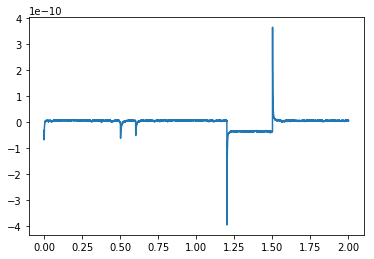

In [11]:
plt.plot(np.mean(test_trial[0][0][0], axis=0), np.mean(test_trial[0][0][1], axis=0))

In [12]:
# Define function for single trace analysis
def single_trace_ana(trial, isi=100, ifartifact=0, samp_rate=25):
    """
    function for extracting usefule information from data
    -------------------
    input:
    trial: response trace, 1d numpy array
    isi: int, inter spike interval of the presynaptic stimulation in ms
    ifartifact: boolean, 0 or 1, whether the trace display artifact or not
    samp_rate: sampling resolution, int in kHz, default 1
    output:
    resp1_amp: float32, amplitude 1
    resp1_t: int, time of the max resp1
    resp2_amp: float32, amplitude 2
    resp2_t: int, time of the max resp2
    rs: Series resistance
    ir: Input resistance
    """
    
    if isi == 1:        # 100ms isi
        if ifartifact:
            stim1_time = 12550
            stim2_time = 15060
        else:
            stim1_time = 12500
            stim2_time = 15030
            
        base_region = np.arange(10500,12400)
        rs_region = np.arange(29000,31150)
        ir_region = np.arange(35000,37000)
    elif isi == 2:      # 200ms isi
        if ifartifact:
            stim1_time = 12550
            stim2_time = 17550
        else:
            stim1_time = 12500
            stim2_time = 17540
            
        base_region = np.arange(10500,12400)
        rs_region = np.arange(40000,41550)
        ir_region = np.arange(44330,46730)
        
    else:                 # 50ms isi
        rs_region = np.arange(24000,26000)
        ir_region = np.arange(28000,32000)
            
        if ifartifact:
            stim1_time = 12550
            stim2_time = 13800
        else:
            stim1_time = 12530
            stim2_time = 13780
        
        base_region = np.arange(10530,12430)

    # Onset of response should be within 2 after pre spike
    base_region = np.arange(stim1_time-1000, stim1_time-1)
    resp1_region = np.arange(stim1_time+2,stim1_time+500)
    resp2_region = np.arange(stim2_time+2,stim2_time+500)
    resp_double_region = np.arange(stim1_time+4,stim1_time+3*(stim2_time-stim1_time))
    
    # Extract info from a single trace
    
    # Remove the baseline
    trial_base = np.mean(trial[base_region])
    trial_demean = np.abs(trial - trial_base)
    base_mean = trial_demean[base_region].mean()
    base_std = trial_demean[base_region].std()
    base_up = base_mean + 2.5*base_std
    
    rs = 0.005/np.max(trial_demean[rs_region])*1e-6  # 5mV stimulation, in Mohm
    
    if rs > 50:
        ir = 0.005/np.mean(trial_demean[ir_region])*1e-6-20
    else:
        ir = 0.005/np.mean(trial_demean[ir_region])*1e-6-rs
    
    if (rs>100)|(rs<5)|(rs==np.inf):
        rs = np.nan
        #trial_demean = trial_demean * 0

    if (ir==np.inf)|(ir>1000):
        ir = np.nan
        trial_demean = trial_demean * 0


    if not ifartifact:
        base1 = np.mean(trial_demean[resp1_region[0]-50:resp1_region[0]-5])
        base2 = np.mean(trial_demean[resp2_region[0]-50:resp2_region[0]-5])
    else:
        base1 = 0
        base2 = 0
    
    resp1_amp = np.max(trial_demean[resp1_region]-base1)
    resp1_dt = np.argmax(trial_demean[resp1_region])
    resp1_t = resp1_dt+resp1_region[0]
    
    resp2_amp = np.max(trial_demean[resp2_region]-base2)
    resp2_dt = np.argmax(trial_demean[resp2_region])
    resp2_t = resp2_dt+resp2_region[0]
    
    # Control the quality of the response
    max_psc = 1e-9
    if (resp1_dt>8*samp_rate)|(resp1_amp<base_up)|(resp1_amp>max_psc):
        resp1_amp=np.nan
        resp1_t=np.nan
        
    if (resp2_dt>8*samp_rate)|(resp2_amp<base_up)|(resp2_amp>max_psc):
        resp2_amp=np.nan
        resp2_t=np.nan
    
    output = {}
    output['trial_demean'] = trial_demean
    output['resp_double_region'] = resp_double_region
    output['resp1_region'] = resp1_region 
    output['resp2_region'] = resp2_region 
    output['resp1_amp'] = resp1_amp
    output['resp1_t'] = resp1_t
    output['resp2_amp'] = resp2_amp
    output['resp2_t'] = resp2_t
    output['rs'] = rs
    output['ir'] = ir
    output['base_up'] = base_up
    
    return output

In [16]:
isi = data_info.iloc[test_idx]['IS100'].astype(int)
output = single_trace_ana(trial=test_trial[0][0][1][0,:], isi=isi, ifartifact=0, samp_rate=25)

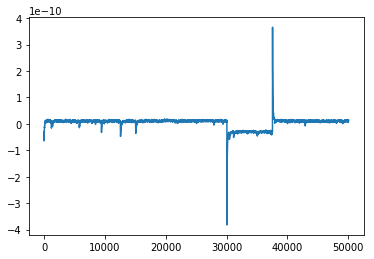

In [17]:
plt.plot(test_trial[0][0][1][0,:])

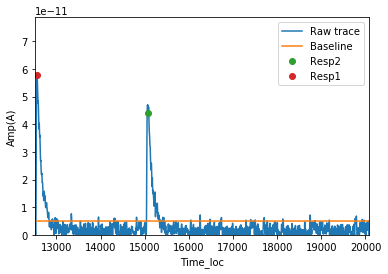

In [19]:
plt.plot(output['trial_demean'], label='Raw trace')
plt.plot(np.arange(output['resp_double_region'][0], output['resp_double_region'][-1]), np.ones(output['resp_double_region'][-1]-output['resp_double_region'][0]) * output['base_up'], label='Baseline')
plt.plot(output['resp2_t'], output['resp2_amp'], 'o', label='Resp2')
plt.plot(output['resp1_t'], output['resp1_amp'], 'o', label='Resp1')
plt.axis([output['resp_double_region'][0], output['resp_double_region'][-1], 0, np.max(output['trial_demean'])/5])
plt.legend()
plt.xlabel('Time_loc')
plt.ylabel('Amp(A)')

In [20]:
# Obtain the onset offset time constant of the averaged trace
def func(x, a, b, c):
    return a * np.exp(-b * x) + c

def time_constant(trace_y, samp_rate=25, iffigure=0):
    """
    Obtain the onset and offset time constant
    ----------------
    input: 
    trace: demeaned response trace, 1d array
    output:
    rise_tau: onset time constant, ms
    decay_tau: decay time constant, ms
    """
    max_amp = np.max(trace_y)
    max_loc = np.argmax(trace_y)
    onset_tau = np.nan
    decay_tau = np.nan
    # Calculate onset time constant
    if 5<max_loc<200:
        trace_y_onset = trace_y[:max_loc]-trace_y[:max_loc].min()
        trace_x_onset = np.arange(len(trace_y_onset))/samp_rate
        # Obtain the 10% - 90% time
        per_90 = np.where(trace_y_onset > trace_y_onset.max() * 0.9)[0]
        per_10 = np.where(trace_y_onset < trace_y_onset.max() * 0.1)[0]
        onset_tau = trace_x_onset[per_90[0]]-trace_x_onset[per_10[-1]]

        # Calculate decay time constant
        trace_y_decay = trace_y[max_loc:]
        trace_x_decay = np.arange(len(trace_y_decay))/samp_rate
        # Nomalize the trace to between 0 and 1

        if iffigure:
            plt.figure()
            plt.plot(trace_x_decay, trace_y_decay)
            plt.xlabel('time(ms)')
            plt.ylabel('amp(pA)')

        try:
            popt, pcov = curve_fit(func, trace_x_decay, trace_y_decay)
            # Evaluate goodness of the fitting
            TSS = np.sum(np.square(trace_y_decay[:20*samp_rate]- trace_y_decay[:20*samp_rate].mean()))
            resi = trace_y_decay[:20*samp_rate] - func(trace_x_decay[:20*samp_rate], *popt)
            RSS = np.sum(np.square(resi))
            R2 = 1 - RSS/TSS

            if iffigure:
                plt.plot(trace_x_decay, func(trace_x_decay, *popt), 'r-',label='fit: a=%5.3f, b=%5.3f, c=%5.3f' % tuple(popt))
                plt.title('R2=%3f'%R2)

            if R2 <= 0.5:
                onset_tau = np.nan
                decay_tau = np.nan
            else:
                decay_tau = 1/popt[1]
        except:
            onset_tau = np.nan
            decay_tau = np.nan
            
    return onset_tau, decay_tau

In [21]:
# Perform batch analysis from averaged trace
def batch_trace_ana(trial, isi=100, ifartifact=0, samp_rate=25, iffigure=0):
    """
    Perform batch analysis from averaged trace
    ----------------
    input:
    trial: response trace, 1d numpy array
    isi: int, inter spike interval of the presynaptic stimulation in ms
    ifartifact: boolean, 0 or 1, whether the trace display artifact or not
    samp_rate: sampling resolution, int in kHz, default 1
    output:
    resp1_amp: float32, amplitude 1
    resp2_amp: float32, amplitude 2
    rs: Series resistance
    ir: Input resistance
    onset_tau: Onset time constant, ms
    decay_tau: Decay time constant, ms
    PPR: Paired pulse ratio
    """
    single_output = single_trace_ana(trial=trial, isi=isi, ifartifact=ifartifact, samp_rate=samp_rate)
    trace_y1 = single_output['trial_demean'][single_output['resp1_region'][0]:single_output['resp1_region'][0]+2000]
    onset_tau1, decay_tau1 = time_constant(trace_y1, samp_rate=samp_rate, iffigure=iffigure)
    trace_y2 = single_output['trial_demean'][single_output['resp2_region'][0]:single_output['resp2_region'][0]+2000]
    onset_tau2, decay_tau2 = time_constant(trace_y2, samp_rate=samp_rate)
    output = {}
    if (onset_tau1+decay_tau1) is not np.nan:
        output['resp1_amp'] = single_output['resp1_amp']
    else:
        output['resp1_amp'] = np.nan
    
    if (onset_tau2+decay_tau2) is not np.nan:
        output['resp2_amp'] = single_output['resp2_amp']
    else:
        output['resp2_amp'] = np.nan
        
    output['PPR'] = output['resp2_amp']/output['resp1_amp']
    output['rs'] = single_output['rs']
    output['ir'] = single_output['ir']
    output['onset_tau1'] = onset_tau1
    output['decay_tau1'] = decay_tau1
    output['trial_demean'] = single_output['trial_demean']
    
    return output

In [22]:
# Plot response from average traces
def sing_trial_ana(trial, index, test_pip, isi=1, ifartifact=0, ave_len=4, samp_rate=25, iffigure=0):
    """
    Plot the averaged data analysis across multiple traces
    ----------------
    Input:
    trial: response matrics, m * recordig length
    index: index of trial to combine for analysis, len k list, k<m
    ave_len: length of points to average
    Outout:
    ave_all: 1d array of averaged response across all traces
    raw_amp1: 1*k array
    raw_amp2: 1*k array
    amp1:
    amp2:
    rs
    ir
    onset_tau:
    decay_tau:
    PPR
    """
    data = []
    for i in range(len(index)):
        data.append(trial[index[i]][0][0][0][0][test_pip-1][0][0][1])
    data = np.vstack(data)
    
    raw_amp1 = np.zeros(data.shape[0])
    raw_amp2 = np.zeros(data.shape[0])
    PPR = []
    resp1_amp = []
    resp2_amp = []
    onset_tau = []
    decay_tau = []
    ir = []
    rs = []
    X = []
    trial_ave = []
    for i in range(data.shape[0]):
        single_output = single_trace_ana(trial=data[i,:], isi=isi, ifartifact=ifartifact, samp_rate=samp_rate)
        raw_amp1[i] = single_output['resp1_amp']
        raw_amp2[i] = single_output['resp2_amp']
        
        if (i+1)*ave_len+2 <= data.shape[0]:
            tmp_trace = np.nanmean(data[i*ave_len:(i+1)*ave_len+2,:],axis=0)
            if (iffigure)&(i%10==0):
                batch_output = batch_trace_ana(trial=tmp_trace, isi=isi, ifartifact=ifartifact, samp_rate=samp_rate, iffigure=1)
            else:
                batch_output = batch_trace_ana(trial=tmp_trace, isi=isi, ifartifact=ifartifact, samp_rate=samp_rate, iffigure=0)
                
            PPR.append(batch_output['PPR'])
            resp1_amp.append(batch_output['resp1_amp'])
            resp2_amp.append(batch_output['resp2_amp'])
            onset_tau.append(batch_output['onset_tau1'])
            decay_tau.append(batch_output['decay_tau1'])
            ir.append(batch_output['ir'])
            rs.append(batch_output['rs'])
            X.append(len(PPR))   # in min 20 s per trace
            trial_ave.append(batch_output['trial_demean'])
            
    output = {}
    output['raw_amp1'] = raw_amp1
    output['raw_amp2'] = raw_amp2
    output['ave_amp1'] = np.vstack(resp1_amp)
    output['ave_amp2'] = np.vstack(resp2_amp)
    output['PPR'] = np.nanmean(PPR)
    output['onset_tau'] = np.nanmean(onset_tau)
    output['decay_tau'] = np.nanmean(decay_tau)
    output['ir'] = np.nanmean(ir)
    output['rs'] = np.nanmean(rs)
    output['x'] = X
    
    output['ave_all'] = trial_ave
    return output

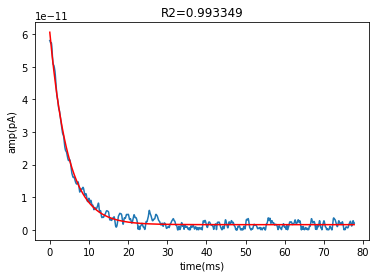

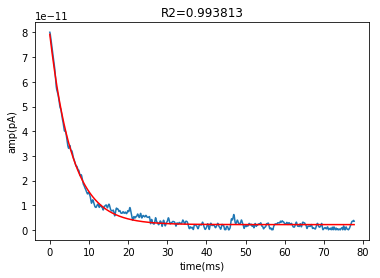

In [33]:
test_pip = data_info.iloc[test_idx]['Pip number']
test_trace_idx = data_info.iloc[test_idx]['Trial number before']
bef_index = [int(s)-1 for s in str.split(test_trace_idx, ',')]
isi = data_info.iloc[test_idx]['IS100'].astype(int)
trial_output = sing_trial_ana(trial=test_data['test'][0], isi=isi, index=bef_index, test_pip=test_pip, ave_len=3, iffigure=1)

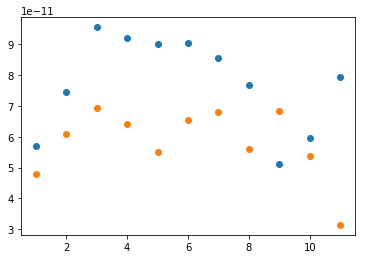

In [34]:
plt.plot(trial_output['x'],trial_output['ave_amp1'], 'o')
plt.plot(trial_output['x'],trial_output['ave_amp2'], 'o')

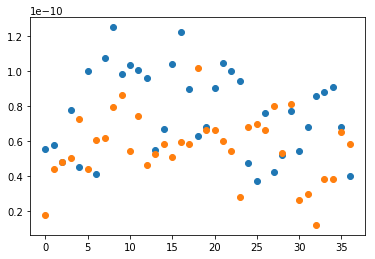

In [35]:
plt.plot(trial_output['raw_amp1'], 'o')
plt.plot(trial_output['raw_amp2'], 'o')

In [53]:
# Analyze response of a trial before and after applying the protocol
def bef_aft_ana(trial, bef_index, aft_index, test_pip, isi=1, ifartifact=0, ave_len=3, samp_rate=25, iffigure=0):
    """
    Analyze response of a trial before and after applying the protocol
    --------------------
    input:
    trial: response matrics, m * recordig length
    bef_index: index of before protocol trial to combine for analysis
    aft_index: index of aft protocol trial to combine for analysis
    ave_len: length of points to average, default 3
    output
    bef_out: dict
    aft_out: dict
    """
    bef_output = sing_trial_ana(trial=trial, index=bef_index, isi=isi, ifartifact= ifartifact, test_pip=test_pip, ave_len=ave_len, iffigure=iffigure)
    aft_output = sing_trial_ana(trial=trial, index=aft_index, isi=isi, ifartifact= ifartifact, test_pip=test_pip, ave_len=ave_len, iffigure=iffigure)
    
    return bef_output, aft_output

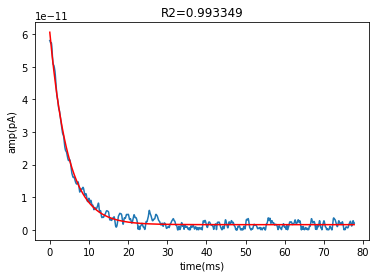

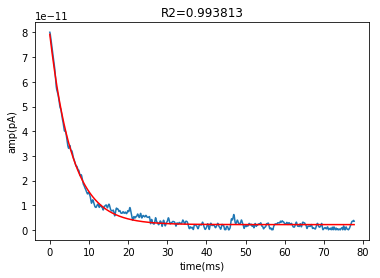

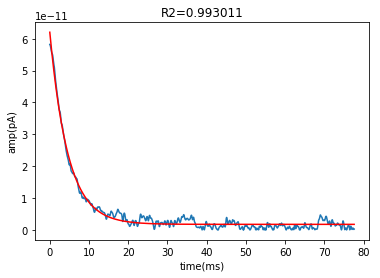

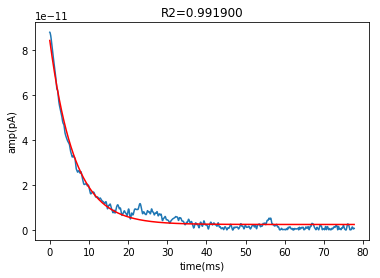

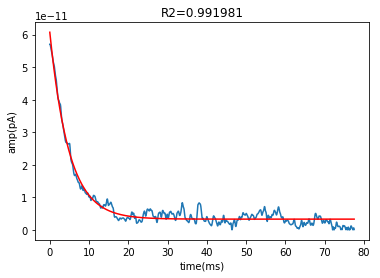

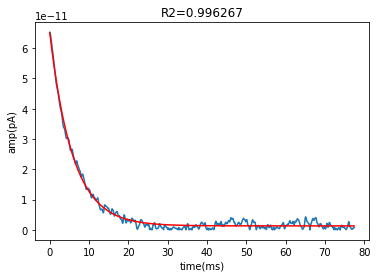

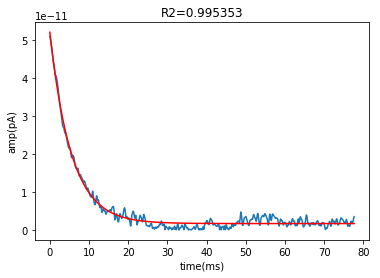

In [54]:
test_trace_idx = data_info.iloc[test_idx]['Trial number before']
bef_index = [int(s)-1 for s in str.split(test_trace_idx, ',')]
test_trace_idx = data_info.iloc[test_idx]['Trial number after']
aft_index = [int(s)-1 for s in str.split(test_trace_idx, ',')]
test_pip = data_info.iloc[test_idx]['Pip number']
isi = data_info.iloc[test_idx]['IS100'].astype(int)
ifartifact = data_info.iloc[test_idx]['Artifact'].astype(int)
bef_output, aft_output = bef_aft_ana(trial=test_data['test'][0], bef_index=bef_index, aft_index=aft_index, test_pip=test_pip, isi=isi, ifartifact=ifartifact, ave_len=3,  iffigure=1)

In [55]:
resp1_joint = np.concatenate([bef_output['ave_amp1'], np.zeros(3).reshape(-1,1), aft_output['ave_amp1']])
resp2_joint = np.concatenate([bef_output['ave_amp2'], np.zeros(3).reshape(-1,1), aft_output['ave_amp2']])

In [56]:
raw1_joint = np.concatenate([bef_output['raw_amp1'], aft_output['raw_amp1']])
raw2_joint = np.concatenate([bef_output['raw_amp2'], aft_output['raw_amp2']])

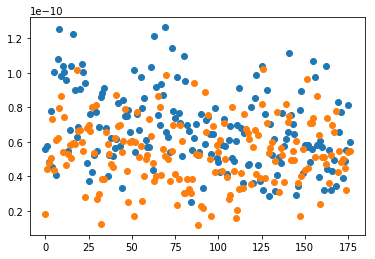

In [57]:
plt.plot(raw1_joint, 'o')
plt.plot(raw2_joint, 'o')

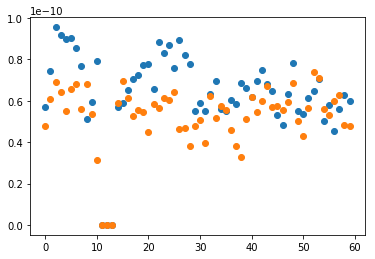

In [58]:
plt.plot(resp1_joint, 'o')
plt.plot(resp2_joint, 'o')

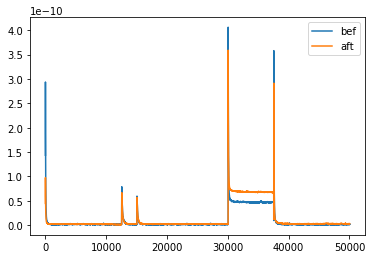

In [59]:
plt.plot(np.mean(bef_output['ave_all'], axis=0), label='bef')
plt.plot(np.mean(aft_output['ave_all'], axis=0), label='aft')
plt.legend()